<h1><a href="http://www.datascience-paris-saclay.fr">Paris Saclay Center for Data Science</a></h1>
<h2>RAMP on Pollinating insect classification</h2>

<i> Mehdi Cherti (CNRS), Romain Julliard (MNHN), Gregoire Lois (MNHN), Balázs Kégl (CNRS)</i><br>
    
<h2>Introduction</h2>

Pollinating insects play a fundamental role in the stability of ecosystems. An insect is said to be pollinator when it transports pollen from one flower to another, helping them to accomplish fertilization. The vast majority of plants pollinates using insects, and at the same time, these insects depend on plants for their survival. However, because of human intensified agrigulture, urbanisation and climate change, these species are threatened. 35% of human alimentation is based on plants pollinated by insects. Diversity of these insects is also important, the more diverse they are the best overall assistance is provided by these insects.

The <a href=http://www.spipoll.org/>SPIPOLL</a> (Suivi Photographique des Insectes POLLinisateurs) project proposes to quantitatively study pollinating insects in France. For this, they created a crowdsourcing platform where anyone can upload pictures of insects and identify their species through a series of questions. These data are then used by specialists for further analyses.

<h2>Data</h2>

In this RAMP, we propose a dataset of pictures of insects from different species gathered from the SPIPOLL project and labeled by specialists. The dataset contains a set of 21004 labeled pictures of insects coming from 18 different insect species. Each picture is a color image. The size of the images (number of pixels) vary.

<h2>The prediction task</h2>

The goal of this RAMP is to classify correctly the species of the insects. For each submission, you will have to provide an image preprocessor (to standardize, resize, crop, augment images) and batch classifier, which will fit a training set and predict the classes (species) on a test set. The images are big so loading them into the memory at once is impossible. The batch classifier therefore will access them through a generator which can be "asked for" a certain number of training and validation images at a time. You will typically run one minibatch of stochastique gradient descent on these images to train a deep convolutional neural networks which are the state of the art in image classification.

<h2>Hints</h2>

First of all, even though 21K images is relatively small compared to industrial level data sets, to achieve state-of-the-art performance, you will need big networks which will take ages (days) to train on a CPU. If you want to have a faster turnaround for tuning your net, you will need a GPU-equipped server of could instance. Setting up an AWS instance is easy, just follow <a href=https://medium.com/@mateuszsieniawski/keras-with-gpu-on-amazon-ec2-a-step-by-step-instruction-4f90364e49ac#.dariq7i2u>this tutorial</a>. 

Your main bottleneck is memory. E.g., increasing the resolution to 128x128, you will need to decrease batch size. You should always run user_test_submission.py on the AWS node before submitting.

For learning the nuts and bolts of convolutional nets, we suggest that you follow <a href=http://cs231n.github.io/>Andrej Karpathy’s excellent course</a>.

You have some trivial "classical" options to explore. You should set the epoch size to something more than three (in the starting kit). You should check when the validation error curve flattens because you will also be graded on training and test time. You can change the network architecture, apply different regularization techniques to control overfitting, optimization options to control underfitting.

You can use pretrained nets from <a href=https://github.com/fchollet/deep-learning-models>here</a>. There are a couple of examples in the starting kit. Your options are the following.
<ol>
<li> Retrain or not the weights. If you do not, you are using the pretrained net as fixed a feature extractor. You can add some layers on the top of the output of the pretrained net, and only train your layers. If you retrain all the layers, you use the pretrained net as an initialization. Again, your goal is not only to increase accuracy but also to be frugal. Retraining the full net is obviously more expensive.
<li> You can "read out" the activations from any layer, you do not need to keep the full net, not even the full convolutional stack.
<li> The training kit contains examples with the VGG16 net, but feel free to use any of the other popular nets. Just note that there is no way to change the architecture of these nets. In partticular, each net expects images of a given dimension so your image preprocessing needs to resize or crop the images to the right size.
</ol>

You can also adjust the image preprocessing. Resizing to small (64x64 or even 32x32) will make the training faster so you can explore more hyperparameters, but the details will be lost so your final result will probably be suboptimal. Insects are mostly centered in the images but there are a lot of smaller insects which could be cropped for a better performance. You can also rotate the images or apply other data augmentation tricks (google "convolutional nets data augmentation"). You should also look at the actual images to get some inspiration to find meaningful preprocessing ideas.

In [1]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import cm

%matplotlib inline

from batch_classifier_workflow import train_submission
from batch_classifier_workflow import test_submission
from batch_classifier_workflow import ArrayContainer

import keras.backend as K
# K.set_image_ordering('tf')
K.set_image_dim_ordering('th')

# set "image_dim_ordering": "th" in ~/.keras/keras.json

Using TensorFlow backend.


# The data

In [2]:
import subprocess

def _get_image_filename(unique_id):
    return 'id_{}.jpg'.format(unique_id)

def _download():
    """
    donwload all images and put them in the folder img/.
    It requires the command 'wget' to exist.
    """
    
    img_folder = 'imgs'
    if not os.path.exists(img_folder):
        os.makedirs(img_folder)
    df = pd.read_csv('train.csv')
    for _, cols in df.iterrows():
        filename = os.path.join(img_folder, _get_image_filename(cols['id']))
        if os.path.exists(filename):
            continue
        url = cols['picture_url']
        cmd = 'wget {} --output-document={}'.format(url, filename)
        subprocess.call(cmd, shell=True)

If the images are not yet in 'imgs', run this. Will take ~1h, depending on connection speed.

In [ ]:
# 
_download()

In [3]:
attrs = {
    'chunk_size': 1024,
    'n_jobs': 8,
    'test_batch_size': 256,
    'folder': 'imgs',
    'n_classes': 18
}

def read_data(filename):
    df = pd.read_csv(filename)
    X_values = df['id'].values
    X = ArrayContainer(X_values, attrs=attrs)
    y = df['class'].values
    return X, y

def get_cv(y_train_array):
    return StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=43)

score_function = accuracy_score

In [4]:
X, y = read_data('train.csv')
cv = get_cv(y)

The class distribution is quite heavy tail: 30% of the images are ordinary bees, and about half of the images belong to the three most populous classes.

In [5]:
train_df = pd.read_csv('train.csv')[['taxa_name', 'taxa_code', 'class']]
labels_df = train_df.groupby('class').max()[['taxa_name']]
counts_df = train_df.groupby('class').count()[['taxa_code']].rename(
    columns={'taxa_code': 'count'})
labels_df = labels_df.join(counts_df).sort_values('count', ascending=False)
labels_df

,taxa_name,count
class,,
3,L'Abeille mellifère (Apis mellifera),6014
0,Les Bourdons noirs à bande(s) jaune(s) et cul ...,3146
2,Le Syrphe ceinturé (Episyrphus balteatus),1819
10,Les Oedemères verts (Oedemera),1163
11,"Les Mouches aux reflets métalliques (Neomyia, ...",1037
16,Les Guêpes Polistes (Polistes),999
7,La Coccinelle à 7 points (Coccinella septempun...,840
5,Le Drap mortuaire (Oxythyrea funesta),810
13,Les Bourdons noirs à bande(s) jaune(s) et cul ...,753


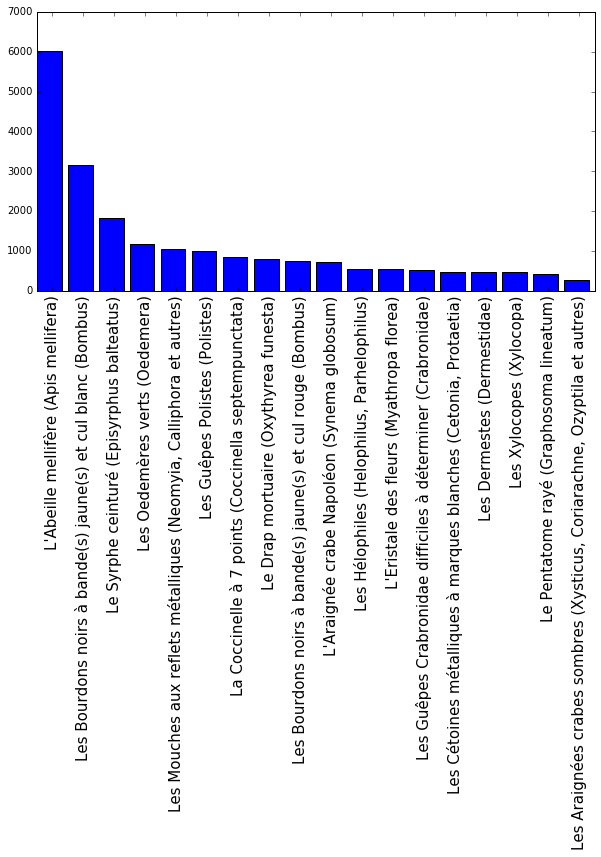

In [6]:
import sys  

reload(sys)  
sys.setdefaultencoding('utf8')

plt.figure(figsize=(10, 5))

x = np.arange(len(labels_df))
plt.bar(x, labels_df['count'])
plt.xticks(x + 0.5, labels_df['taxa_name'], rotation=90, fontsize=15);

It is worthwhile to look at some image panels, grouped by label. 

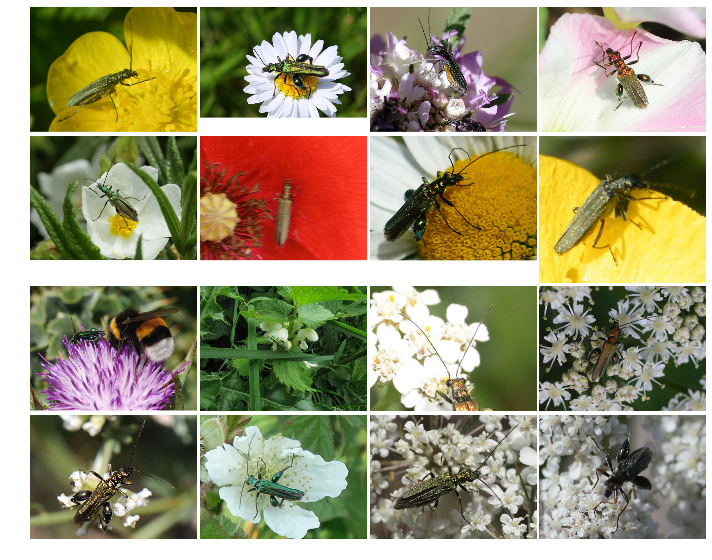

In [7]:
nb_rows = 4
nb_cols = 4
nb_elements = nb_rows * nb_cols
label = 10

print("{0}".format(labels_df.loc[label]))

X_given_label = X[y==label]

subsample = np.random.choice(X_given_label, replace=False, size=nb_elements)

fig = plt.figure(figsize=(10, 10))
grid = AxesGrid(fig, 111, # similar to subplot(141)
                nrows_ncols = (nb_rows, nb_cols),
                axes_pad = 0.05,
                label_mode = "1",
)
for i, image_id in enumerate(subsample):
    filename = 'imgs/id_{}.jpg'.format(image_id)
    image = imread(filename)
    im = grid[i].imshow(image/255.)
    grid[i].axis('off')
plt.tight_layout()

All images have width 1024, with varying height (40% has 768).

In [8]:
n_subsample = 1000
shapes = np.empty((n_subsample, 3))
for i, image_id in enumerate(X[:n_subsample]):
    filename = 'imgs/id_{}.jpg'.format(image_id)
    image = imread(filename)
    shapes[i] = image.shape

In [9]:
shapes_df = pd.DataFrame(shapes,columns=['height', 'width', 'count'])
shapes_df.groupby(['height', 'width']).count().sort_values('count', ascending=False)

,,count
height,width,
768.0,1024.0,401
1365.0,1024.0,112
769.0,1024.0,59
767.0,1024.0,42
770.0,1024.0,28
1364.0,1024.0,21
678.0,1024.0,19
771.0,1024.0,18
766.0,1024.0,18


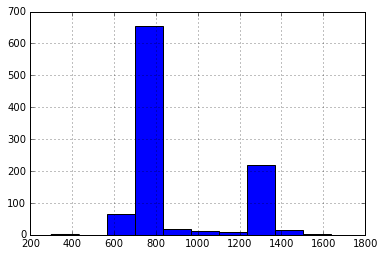

In [10]:
shapes_df['height'].hist()

# Image preprocessing

In the first workflow element image_preprocessor.py you can resize, crop, or rotate the images. This is an important step. Neural nets need standard-size images defined by the dimension of the input layer. Larger images can contain more detail but they are heavier on memory and training time. Most insects are in the middle of the image, so cropping can be a good strategy (especially non-standard portrait type photos which may be distorted in the "wrong" way by simply resizing). Data augmentation by careful random transformations (resize, crop, but also rotate) could be another option to explore.

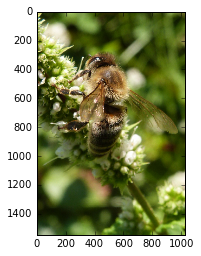

In [11]:
filename = 'imgs/id_{}.jpg'.format(X[161])
image = imread(filename)
plt.imshow(image/255.)
plt.show()

Here we resize the images to different resolutions, then blow them up so the difference can be visible.

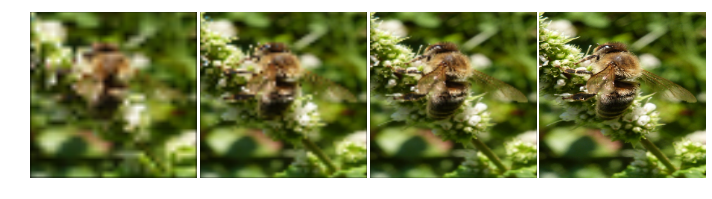

In [12]:
from skimage.transform import resize

nb_rows = 1
nb_cols = 4
nb_elements = nb_rows * nb_cols


fig = plt.figure(figsize=(10, 10))
grid = AxesGrid(fig, 111, # similar to subplot(141)
                nrows_ncols = (nb_rows, nb_cols),
                axes_pad = 0.05,
                label_mode = "1",
)
grid[0].imshow(resize(resize(image, (32, 32), preserve_range=True)/255., (224, 224)))
grid[0].axis('off')
grid[1].imshow(resize(resize(image, (64, 64), preserve_range=True)/255., (224, 224)))
grid[1].axis('off')
grid[2].imshow(resize(resize(image, (128, 128), preserve_range=True)/255., (224, 224)))
grid[2].axis('off')
grid[3].imshow(resize(resize(image, (224, 224), preserve_range=True)/255., (224, 224)))
grid[3].axis('off')
plt.tight_layout()

Here we crop the middle of the image before resizing so there is no distrotion.

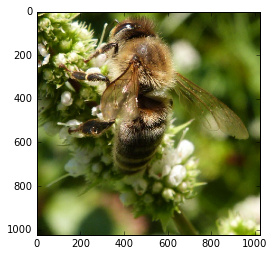

In [13]:
h, w = image.shape[:2]
min_shape = min(h, w)
cropped_image = image[h/2 - min_shape / 2:h/2 + min_shape / 2,
                      w/2 - min_shape / 2:w/2 + min_shape / 2]
plt.imshow(cropped_image/255.)
plt.show()

Here we rotate the image. Explore options in skimage.

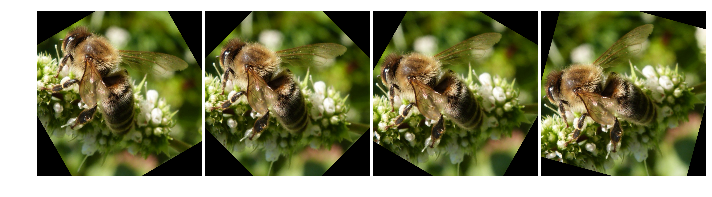

In [14]:
from skimage.transform import rotate

nb_rows = 1
nb_cols = 4
nb_elements = nb_rows * nb_cols

fig = plt.figure(figsize=(10, 10))
grid = AxesGrid(fig, 111, # similar to subplot(141)
                nrows_ncols = (nb_rows, nb_cols),
                axes_pad = 0.05,
                label_mode = "1",
)
grid[0].imshow(rotate(cropped_image, 30, preserve_range=True)/255.)
grid[0].axis('off')
grid[1].imshow(rotate(cropped_image, 45, preserve_range=True)/255.)
grid[1].axis('off')
grid[2].imshow(rotate(cropped_image, 60, preserve_range=True)/255.)
grid[2].axis('off')
grid[3].imshow(rotate(cropped_image, 75, preserve_range=True)/255.)
grid[3].axis('off')
plt.tight_layout()

All these tansformations should be implemented in the transform function found in the image_preprocessor workflow element that you will submit.

Note the safeguard that checks if the number of channels (x.shape[2]) is 4. Normally each image has three (RGB) channels, but some of them also contains an opacity channel which we need to ignore.

In [ ]:
# %load image_preprocessor.py
import numpy as np
from skimage.transform import resize

def transform(x):
    if x.shape[2] == 4:
        x = x[:, :, 0:3]
    x = resize(x, (64, 64), preserve_range=True)
    x = x / 255.
    x = x.transpose((2, 0, 1))
    return x

In [ ]:
# %load pretrained/image_preprocessor.py
import numpy as np
from skimage.transform import resize

def transform(x):
    if x.shape[2] == 4:
        x = x[:, :, 0:3]
    x = resize(x, (224, 224), preserve_range=True)
    x = x.transpose((2, 0, 1))
    # 'RGB'->'BGR'
    x = x[::-1, :, :]
    # Zero-center by mean pixel
    x[0, :, :] -= 103.939
    x[1, :, :] -= 116.779
    x[2, :, :] -= 123.68
    return x

# The batch classifier workflow

The data set is too big to be loaded in the memory at once, so instead of a set of images, your batch_classifier.fit function will receive a <i>generator</i>. The type of this generator is BatchGeneratorBuilder. You will interact with it by calling its get_train_valid_generators function. This function will still not return data, since typically you would call the fit function of a keras neural net with it, which would again result in filling the memory too fast. Instead, it returns two other generators that you will pass to the fit_generator function of a keras model. Why two? The first generator will generate training images for keras, and the second generator generates validation images, which you can use to monitor the learning curves when developing the model. Normally you will not need validation samples in your submission (only when you develop your models outside of the RAMP server) unless you implement automatic early stopping based on validation accuracy.

The BatchGeneratorBuilder.get_train_valid_generators function expects two parameters: valid_ratio (the ratio of the minibatch that should be used for validation, typically 0.1) and batch_size (the number of images keras fit_generator will get for every minibatch). The batch size is an important hyperparameter. Statistically, a larger batch size means more precise gradient estimates but computationally slower steps. But more importantly, you will have to carefully set the batch size for staying within the memory, depending on the input image size and your network architecture. In the examples in the user test, we use 64, 32, or 8 images per minibatch.

In [188]:
# %load batch_classifier_workflow
import os
import time
import threading
from importlib import import_module

from joblib import delayed
from joblib import Parallel

import numpy as np
from skimage.io import imread

from keras.utils.np_utils import to_categorical


def train_submission(module_path, X_array, y_array, train_is):
    """
    module_path : str
        module where the submission is. the folder of the module
        have to contain batch_classifier.py and image_preprocessor.py.
    X_array : ArrayContainer vector of int
        vector of image IDs to train on
        (it is named X_array to be coherent with the current API,
         but as said here, it does not represent the data itself,
         only image IDs).
    y_array : vector of int
        vector of image labels corresponding to X_train
    train_is : vector of int
       indices from X_array to train on 
    """

    # If module_path is not empty (not a local module)
    # add the "." prefix.
    # This is to deal with the import of batch_classifier.py and 
    # image_preprocessor.py in two different contexts : 
    # in the context of a submission (the folder submissions/)
    # and in the context of the starting kit.
    # For a submission, module_path refers to 'submissions.submission_name'.
    # In that case, add a '.' to have e.g 'submissions.submission_name.batch_classifier'.
    # For the starting kit, module_path is '', in that case we just import
    # e.g 'batch_classifier'.
    if module_path:
        module_path += '.'
    batch_classifier = import_module(module_path + 'batch_classifier')
    image_preprocessor = import_module(module_path + 'image_preprocessor')
    transform_img = image_preprocessor.transform
    clf = batch_classifier.BatchClassifier()
    attrs = X_array.attrs
    test_batch_size = attrs['test_batch_size']
    chunk_size = attrs['chunk_size']
    n_jobs = attrs['n_jobs']
    n_classes = attrs['n_classes']
    folder = attrs['folder']
    gen_builder = BatchGeneratorBuilder(
        X_array[train_is], y_array[train_is],
        transform_img,
        folder=folder,
        chunk_size=chunk_size,
        n_classes=n_classes,
        n_jobs=n_jobs)
    clf.fit(gen_builder)
    return transform_img, clf


def test_submission(trained_model, X_array, test_is):
    """
    trained_model : tuple (function, Classifier)
        tuple of a trained model returned by `train_submission`.
    X_array : ArrayContainer of int
        vector of image IDs to test on.
        (it is named X_array to be coherent with the current API,
         but as said here, it does not represent the data itself,
         only image IDs).
    test_is : vector of int
       indices from X_array to test on 
    """
    transform_img, clf = trained_model
    attrs = X_array.attrs
    test_batch_size = attrs['test_batch_size']
    chunk_size = attrs['chunk_size']
    n_jobs = attrs['n_jobs']
    folder = attrs['folder']
    it = chunk_iterator(
        X_array[test_is], 
        chunk_size=chunk_size, 
        folder=folder)
    y_proba = []
    for X in it:
        for i in range(0, len(X), test_batch_size):
            # 1) Preprocessing
            X_batch = X[i:i + test_batch_size]
            X_batch = Parallel(n_jobs=n_jobs, backend='threading')(delayed(transform_img)(x) for x in X_batch)
            # X_batch is a list of numpy arrrays at this point, convert it to a single numpy 
            # array of size `test_batch_size` (at most).
            X_batch = [x[np.newaxis, :, :, :] for x in X_batch]
            X_batch = np.concatenate(X_batch, axis=0)

            # 2) Prediction
            y_proba_batch = clf.predict_proba(X_batch)
            y_proba.append(y_proba_batch)
    y_proba = np.concatenate(y_proba, axis=0)
    return y_proba


class BatchGeneratorBuilder(object):
    """
    This class is a way to build training and 
    validation generators that yield each time a tuple (X, y) of mini-batches. 
    The generators are built in a way to fit into keras API of `fit_generator`
    (see https://keras.io/models/model/).
    An instance of this class is exposed to users `Classifier` through
    the `fit` function : model fitting is called by using
    "clf.fit(gen_builder)" where `gen_builder` is an instance
    of this class : `BatchGeneratorBuilder`.
    The fit function from `Classifier` should then use the instance
    to build train and validation generators, using the method
    `get_train_valid_generators`

    Parameters
    ==========
        
    X_array : ArrayContainer of int
        vector of image IDs to train on
         (it is named X_array to be coherent with the current API,
         but as said here, it does not represent the data itself,
         only image IDs).

    y_array : vector of int
        vector of image labels corresponding to `X_array`

    folder : str
        folder where the images are

    chunk_size : int
        size of the chunk used to load data from disk into memory.
        (see at the top of the file what a chunk is and its difference
         with the mini-batch size of neural nets).

    n_classes : int
        Total number of classes. This is needed because the array
        of labels, which is a vector of ints, is transformed into
        a onehot representation.

    n_jobs : int
        the number of jobs used to load images from disk to memory as `chunks`.
    """
    def __init__(self, X_array, y_array, 
                 transform_img,
                 folder='imgs', 
                 chunk_size=1024,
                 n_classes=18,
                 n_jobs=8):
        self.X_array = X_array
        self.y_array = y_array
        self.transform_img = transform_img
        self.folder = folder
        self.chunk_size = chunk_size
        self.n_classes = n_classes
        self.n_jobs = n_jobs
        self.nb_examples = len(X_array)
    
    def get_train_valid_generators(self, batch_size=256, valid_ratio=0.1):
        """
        This method is used by the user defined `Classifier` to o build train and 
        valid generators that will be used in keras `fit_generator`.

        Parameters
        ==========

        batch_size : int
            size of mini-batches
        valid_ratio : float between 0 and 1
            ratio of validation data

        Returns
        =======

        a 4-tuple (gen_train, gen_valid, nb_train, nb_valid) where:
            - gen_train is a generator function for training data
            - gen_valid is a generator function for valid data
            - nb_train is the number of training examples
            - nb_valid is the number of validation examples
        The number of training and validation data are necessary
        so that we can use the keras method `fit_generator`.
        """
        nb_valid = int(valid_ratio * self.nb_examples)
        nb_train = self.nb_examples - nb_valid
        indices = np.arange(self.nb_examples)
        train_indices = indices[0:nb_train]
        valid_indices = indices[nb_train:]
        gen_train = self._get_generator(
            indices=train_indices, batch_size=batch_size)
        gen_valid = self._get_generator(
            indices=valid_indices, batch_size=batch_size)
        return gen_train, gen_valid, nb_train, nb_valid

    def _get_generator(self, indices=None, batch_size=256):
        if indices is None:
            indices = np.arange(self.nb_examples)
        # Infinite loop, as required by keras `fit_generator`.
        # However, as we provide the number of examples per epoch
        # and the user specifies the total number of epochs, it will
        # be able to end.
        while True:
            it = chunk_iterator(
                X_array=self.X_array[indices],
                y_array=self.y_array[indices], 
                chunk_size=self.chunk_size, 
                folder=self.folder,
                n_jobs=self.n_jobs)
            for X, y in it:
                # 1) Preprocessing of X and y
                X = Parallel(n_jobs=self.n_jobs, backend='threading')(delayed(self.transform_img)(x) for x in X)
                # X is a list of numpy arrrays at this point, convert it to a single numpy array.
                X = [x[np.newaxis, :, :, :] for x in X]
                X = np.concatenate(X, axis=0)
                X = np.array(X, dtype='float32')
                # Convert y to onehot representation
                y = to_categorical(y, nb_classes=self.n_classes)

                # 2) Yielding mini-batches
                for i in range(0, len(X), batch_size):
                    yield X[i:i + batch_size], y[i:i + batch_size]

def chunk_iterator(X_array, y_array=None, chunk_size=1024, folder='imgs', n_jobs=8):
    """
    Generator function that yields chunks of images, optionally with their labels.

    Parameters
    ==========
    
    X_array : ArrayContainer of int
        image ids to load
        (it is named X_array to be coherent with the current API,
         but as said here, it does not represent the data itself,
         only image IDs).

    y_array : vector of int
        labels corresponding to each image from X_array

    chunk_size : int
        chunk size

    folder : str
        folder where the images are

    n_jobs : int
        number of jobs used to load images in parallel

    Yields
    ======

    if y_array is provided (not None):
        it yields each time a tuple (X, y) where X is a list
        of numpy arrays of images and y is a list of ints (labels).
        The length of X and y is `chunk_size` at most (it can be smaller).

    if y_array is not provided (it is None) 
        it yields each time X where X is a list of numpy arrays
        of images. The length of X is `chunk_size` at most (it can be smaller).
        This is used for testing, where we don't have/need the labels.

    The shape of each element of X in both cases
    is (height, width, color), where color is 1 or 3 or 4 and height/width
    vary according to examples (hence the fact that X is a list instead of numpy array).
    """
    for i in range(0, len(X_array), chunk_size):
        X_chunk = X_array[i:i + chunk_size]
        filenames = map(_get_image_filename_from_id, X_chunk)
        filenames = map(lambda filename:os.path.join(folder, filename), filenames)
        X = Parallel(n_jobs=n_jobs, backend='threading')(delayed(imread)(filename) for filename in filenames)
        if y_array is not None:
            y = y_array[i:i + chunk_size]
            yield X, y
        else:
            yield X

def _get_image_filename_from_id(unique_id):
    return 'id_{}.jpg'.format(unique_id)

class ArrayContainer(np.ndarray):
    """
    This is an extension of numpy arrays with attributes.
    It follows the guidelines from numpy documentation to
    subclass numpy arrays to have new attributes.
    (Check : https://docs.scipy.org/doc/numpy/user/basics.subclassing.html).
    It is used to pass a set of global variables from the problem
    to the workflow `batch_classifier_workflow`. 
    The global variables that are passed (and they are obligatory):
    - chunk_size,
    - n_jobs,
    - test_batch_size,
    - folder
    - n_classes
    """
    
    def __new__(cls, input_array, attrs=None):
        # Input array is an already formed ndarray instance
        # We first cast to be our class type
        obj = np.asarray(input_array).view(cls)
        # add the new attribute to the created instance
        obj.attrs = attrs
        # Finally, we must return the newly created object:
        return obj

    def __array_finalize__(self, obj):
        # see InfoArray.__array_finalize__ for comments
        if obj is None: return
        self.attrs = getattr(obj, 'attrs', None)



Your convnet models will be implemented in the batch_classifier.py workflow element. The model is usually implemented in a separate build_model function which is called from init. It does not do any computation, just building the network architecture. The architecture in the starting kit is coming from VGG16 that you can access with other state-of-the-art nets <a href=https://github.com/fchollet/deep-learning-models>here</a>. Your main task is to find the right architecture for this data set. Every parameter is "free" the size of the input layer (which should match the preprocessing you do in image_preprocessing.trasform), the number and composition of the convolutional blocks, the size and number of filters in each layer, the number and size of the fully connected layers, the regulariztion that you apply (usually only on the fully connected layers), and the optimizer. In addition, in the fit function you shold decide the size of the minibatches and the number of epochs. 

In [ ]:
# %load batch_classifier.py
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Convolution2D
from keras.layers import ZeroPadding2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.optimizers import Adam

class BatchClassifier(object):
    
    def __init__(self):
        self.model = build_model()
    
    def fit(self, gen_builder):
        gen_train, gen_valid, nb_train, nb_valid = gen_builder.get_train_valid_generators(batch_size=64, valid_ratio=0.1)
        self.model.fit_generator(
                gen_train,
                samples_per_epoch=nb_train,
                nb_epoch=3,
                # In parallel to training, a CPU process loads and preprocesses data from disk and put
                # it into a queue in the form of mini-batches of size `batch_size`.`max_q_size` controls 
                # the maximum size of that queue.
                # The size of the queue should be big enough so that the training process (GPU) never
                # waits for data (the queue should be never be empty). 
                # The CPU process loads chunks of 1024 images each time, and
                # 1024/batch_size mini-batches from that chunk are put into the queue.
                # Assuming training the model on those 1024/batch_size mini-batches is slower than 
                # loading a single chunk of 1024 images, a good lower bound for `max_q_size` would be
                # (1024/batch_size). if `batch_size` is 64, you can put `max_q_size` to 16.
                max_q_size=16,
                # WARNING : It is obligatory to set `nb_worker` to 1.
                # This in principle controls the number of workers used
                # by keras to load mini-batches from disk to memory in parallel
                # to GPU training. But I don't like the way it works and their
                # code is not very commented/used, so I dont trust it that much
                # (we might have surprises).
                # The way it works in keras is by launching in parallel `nb_worker` 
                # threads or processes which will all use a copy of the generator passed.
                # to `fit_generator`. So if nothing is done and `nb_worker` is set to 
                # some number > 1, the neural net will be trained with repetitions 
                # of the same data, because the workers are independent and they got 
                # through the same generator. 
                # Hence it is necessary to introduce a shared lock between the the 
                # processes so that they load different data, this can become a bit 
                # complicated, so I choose to rather load exactly one chunk at a time using 
                # 1 worker (so `nb_worker` have to be equal to 1), but do this single
                # chunk loading in parallel with joblib.
                nb_worker=1,
                # if pickle_safe is True, processes are used instead of threads.
                # here, 1 process is used because `nb_worker` is 1.
                pickle_safe=True,
                validation_data=gen_valid,
                nb_val_samples=nb_valid,
                verbose=1)

    def predict_proba(self, X):
        return self.model.predict(X)
        
def build_model():
    # This is VGG16
    inp = Input((3, 64, 64))
    # Block 1
    x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1')(inp)
    x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    # Block 2
    x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv1')(x)
    x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    # Block 3
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv1')(x)
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv2')(x)
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    # Block 4
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv1')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv3')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
    # Block 5
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv1')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv3')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    # dense
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    out = Dense(18, activation='softmax', name='predictions')(x)
    model = Model(inp, out)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy'])
    return model


The following will take a long time if you have no GPUs. You can change the example submission from small to pretrained or ptrtrained_inter, but even the small net will take roughly an hour to train.

In [ ]:
for train_is, test_is in cv.split(X, y):
    print("Training ...")
    trained_model = train_submission('small', X, y, train_is)
    print("Testing ...")
    y_pred = test_submission(trained_model, X, test_is)
    print(y[test_is].shape, y_pred[test_is].shape)
    score = score_function(y[test_is], y_pred[test_is].argmax(axis=1))
    print('accuracy = ', score)

## Pretrained nets

In our experience, with the moderate data size we have in this challenge, the best performance is achieved with pretrained nets. When you use a pretrained net, you are copying not only the architecture but also the weights that were saved after training the net, usually on ImageNet. You have some options. 1) include_top means that you also copy the fully connected net from the pretrained net. Usually we do not do that, rather design and traing our fully connected layer on top of the last convolutional layer. 2) trainable means that you retrain also the convolutional weights. If True, it means that you use the pretrained net as an initializer, set to False means you use the pretrained net as a fixed feature extractor.

Note that when you use a pretrained net, the image size must match the size that was used to train the net. In current ImageNet classifiers this is rather large (e.g., 224 x 224) which means that you need to decrease the batch size not to crash the GPU memory.

In [ ]:
# %load pretrained/batch_classifier.py
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Convolution2D
from keras.layers import ZeroPadding2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam, SGD

class BatchClassifier(object):
    
    def __init__(self):
        self.model = build_model()
    
    def fit(self, gen_builder):
        gen_train, gen_valid, nb_train, nb_valid = gen_builder.get_train_valid_generators(batch_size=16, valid_ratio=0.1)
        self.model.fit_generator(
                gen_train,
                samples_per_epoch=nb_train,
                nb_epoch=30,
                # In parallel to training, a CPU process loads and preprocesses data from disk and put
                # it into a queue in the form of mini-batches of size `batch_size`.`max_q_size` controls 
                # the maximum size of that queue.
                # The size of the queue should be big enough so that the training process (GPU) never
                # waits for data (the queue should be never be empty). 
                # The CPU process loads chunks of 1024 images each time, and
                # 1024/batch_size mini-batches from that chunk are put into the queue.
                # Assuming training the model on those 1024/batch_size mini-batches is slower than 
                # loading a single chunk of 1024 images, a good lower bound for `max_q_size` would be
                # (1024/batch_size). if `batch_size` is 16, you can put `max_q_size` to 64.
                max_q_size=64,
                # WARNING : It is obligatory to set `nb_worker` to 1.
                # This in principle controls the number of workers used
                # by keras to load mini-batches from disk to memory in parallel
                # to GPU training. But I don't like the way it works and their
                # code is not very commented/used, so I dont trust it that much
                # (we might have surprises).
                # The way it works in keras is by launching in parallel `nb_worker` 
                # threads or processes which will all use a copy of the generator passed.
                # to `fit_generator`. So if nothing is done and `nb_worker` is set to 
                # some number > 1, the neural net will be trained with repetitions 
                # of the same data, because the workers are independent and they got 
                # through the same generator. 
                # Hence it is necessary to introduce a shared lock between the the 
                # processes so that they load different data, this can become a bit 
                # complicated, so I choose to rather load exactly one chunk at a time using 
                # 1 worker (so `nb_worker` have to be equal to 1), but do this single
                # chunk loading in parallel with joblib.
                nb_worker=1,
                # if pickle_safe is True, processes are used instead of threads.
                # here, 1 process is used because `nb_worker` is 1.
                pickle_safe=True,
                validation_data=gen_valid,
                nb_val_samples=nb_valid,
                verbose=1)

    def predict_proba(self, X):
        return self.model.predict(X)
        
def build_model():
    vgg16 = VGG16(include_top=False, weights='imagenet')
    #vgg16.trainable = False
    inp = Input((3, 224, 224))
    x = vgg16(inp)
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    out = Dense(18, activation='softmax', name='predictions')(x)
    model = Model(inp, out)
    model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=1e-4), metrics=['accuracy'])
    return model


Finally, you can also decide not to use the full pretrained net, rather "read out" the features from any layer in the convolutional block. 

In [ ]:
# %load pretrained_interm/batch_classifier.py
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Convolution2D
from keras.layers import ZeroPadding2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam, SGD

class BatchClassifier(object):
    
    def __init__(self):
        self.model = build_model()
    
    def fit(self, gen_builder):
        gen_train, gen_valid, nb_train, nb_valid = gen_builder.get_train_valid_generators(batch_size=16, valid_ratio=0.1)
        self.model.fit_generator(
                gen_train,
                samples_per_epoch=nb_train,
                nb_epoch=30,
                # In parallel to training, a CPU process loads and preprocesses data from disk and put
                # it into a queue in the form of mini-batches of size `batch_size`.`max_q_size` controls 
                # the maximum size of that queue.
                # The size of the queue should be big enough so that the training process (GPU) never
                # waits for data (the queue should be never be empty). 
                # The CPU process loads chunks of 1024 images each time, and
                # 1024/batch_size mini-batches from that chunk are put into the queue.
                # Assuming training the model on those 1024/batch_size mini-batches is slower than 
                # loading a single chunk of 1024 images, a good lower bound for `max_q_size` would be
                # (1024/batch_size). if `batch_size` is 16, you can put `max_q_size` to 64.
                max_q_size=16,
                # WARNING : It is obligatory to set `nb_worker` to 1.
                # This in principle controls the number of workers used
                # by keras to load mini-batches from disk to memory in parallel
                # to GPU training. But I don't like the way it works and their
                # code is not very commented/used, so I dont trust it that much
                # (we might have surprises).
                # The way it works in keras is by launching in parallel `nb_worker` 
                # threads or processes which will all use a copy of the generator passed.
                # to `fit_generator`. So if nothing is done and `nb_worker` is set to 
                # some number > 1, the neural net will be trained with repetitions 
                # of the same data, because the workers are independent and they got 
                # through the same generator. 
                # Hence it is necessary to introduce a shared lock between the the 
                # processes so that they load different data, this can become a bit 
                # complicated, so I choose to rather load exactly one chunk at a time using 
                # 1 worker (so `nb_worker` have to be equal to 1), but do this single
                # chunk loading in parallel with joblib.
                nb_worker=1,
                # if pickle_safe is True, processes are used instead of threads.
                # here, 1 process is used because `nb_worker` is 1.
                pickle_safe=True,
                validation_data=gen_valid,
                nb_val_samples=nb_valid,
                verbose=1)

    def predict_proba(self, X):
        return self.model.predict(X)
        
def build_model():
    vgg16 = VGG16(include_top=False, weights='imagenet')
    vgg16.trainable = False
    inp = vgg16.get_layer(name='input_1')
    hid = vgg16.get_layer(name='block3_conv3')
    vgg16_hid = Model(inp.input, hid.output)

    inp = Input((3, 224, 224))
    x = vgg16_hid(inp)
    x = Flatten(name='flatten')(x)
    x = Dense(500, activation='relu', name='fc')(x)
    out = Dense(18, activation='softmax', name='predictions')(x)
    model = Model(inp, out)
    model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=1e-4, momentum=0.95), metrics=['accuracy'])
    return model


Don't forget to run

python user_test_submission.py

before submitting.